# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

## 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

## 2. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
import pickle

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
# if scikit-learn version >= 0.18
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

The scikit-learn version is 0.19.0.


In [3]:
# Extract features from a list of images
# Have this function call bin_spatial(), color_hist() and get_hog_features()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        image = (image*255).astype(np.uint8)
        
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        
        file_features = []
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        # [[spatial_features], [hist_features], [hog_features]] 
        # ---> [spatial_features, hist_features, hog_features]
        features.append(np.concatenate(file_features))
        
    return features


# Compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features


# Compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


# HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image

    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

8792 car images, and  8968 notcar images


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4464


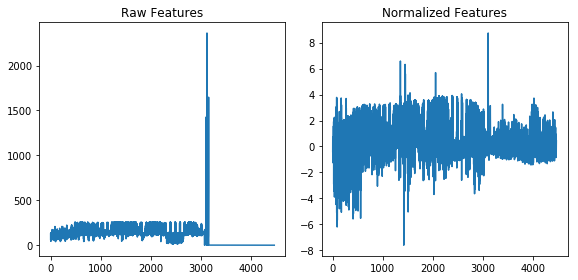

In [4]:
# Read in cars and notcars
car_images = glob.glob('./dataset/png/car/**/*.png')
cars = []
for image in car_images:
    cars.append(image)
        
notcar_images = glob.glob('./dataset/png/notcar/**/*.png')        
notcars = []
for image in notcar_images:
    notcars.append(image)

print(len(cars), "car images, and ", len(notcars), "notcar images")
        
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12 # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
window = 64 #[pix]


spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
'''
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
'''
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Combine the features
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)

# If use color features also, normalize the features
if spatial_feat == True or hist_feat == True:
    scaled_X = X_scaler.transform(X)
# If use HOG feature only, don't normalize the feature
elif hog_feat == True:
    scaled_X = X

# Plot an example of raw and scaled features
car_ind = np.random.randint(0, len(cars))
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(132)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

# Define the labels vector, '1' as a car, '0' as a notcar
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

In [5]:
# Classifier
svc = SVC(C=1, kernel='linear')

# Check the training time for the classifier
t0 = time.time()
svc.fit(X_train, y_train)
t = time.time()
print(round(t-t0, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Save the parameters including the classifier
parameters_dict = {'color_space':color_space,
                   'orient':orient,
                   'pix_per_cell':pix_per_cell,
                   'cell_per_block':cell_per_block,
                   'hog_channel':hog_channel,
                   'spatial_size':spatial_size,
                   'hist_bins':hist_bins,
                   'window':window,
                   'spatial_feat':spatial_feat,
                   'hist_feat':hist_feat,
                   'hog_feat':hog_feat,
                   'X_scaler':X_scaler,
                   'svc':svc}
print("Saving...")
parameters_file = './parameters_dict.p'
with open(parameters_file, mode='wb') as f:
    pickle.dump(parameters_dict, f)
print("The parameters have been saved")

59.36 Seconds to train SVC...
Test Accuracy of SVC =  0.9927
Saving...
The parameters have been saved


## 3. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [6]:
# Extract features using hog sub-sampling and make predictions
def find_cars(img, color_space, ystart, ystop, scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    
    #img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop, :, :]
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        else: 
            ctrans_tosearch = np.copy(img_tosearch)       
            
    ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(ctrans_tosearch.shape[1]/scale), np.int(ctrans_tosearch.shape[0]/scale)))
        
    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]
    
    # Compute individual channel HOG features for the entire image
    # hog*.shape = (nyblocks, nxblocks, cell_per_block, cell_per_block, orient)
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #print("\n scale=", scale)
    #print(ch1.shape, "--->", hog1.shape)

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1]//pix_per_cell) - (cell_per_block-1)
    nyblocks = (ch1.shape[0]//pix_per_cell) - (cell_per_block-1)
    #print("nxblocks=", nxblocks, ", nyblocks=", nyblocks)
    
    nblocks_per_window = (window//pix_per_cell) - (cell_per_block-1)
    #print("nblocks/window=", nblocks_per_window)
    xcells_per_step = 2 # Instead of overlap, define how many cells to step
    ycells_per_step = int(np.ceil(xcells_per_step*0.5)) # Half of xcells_per_step
    nxsteps = (nxblocks-nblocks_per_window) // xcells_per_step + 1
    nysteps = (nyblocks-nblocks_per_window) // ycells_per_step + 1
    #print("nxsteps=", nxsteps, ", nysteps=", nysteps)
    
    detected_window = []
    for yb in range(nysteps):
        for xb in range(nxsteps):
            xpos = xb * xcells_per_step
            ypos = yb * ycells_per_step
            
            # Extract HOG for this patch
            # hog*.shape = (nyblocks, nxblocks, cell_per_block, cell_per_block, orient)
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            # Extract the image patch
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # If use color features also, normalize the features
            if spatial_feat == True or hist_feat == True:
                # Get color features, concatenate HOG and color features, and normalize it
                subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))            
            # If use HOG feature only, don't normalize the feature
            elif hog_feat == True:
                test_features = hog_features.reshape(1, -1)
            
            # Scale features and make a prediction
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
            #if test_prediction == 1 or test_prediction == 0:
                xleft_draw = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale) + ystart
                win_draw = np.int(window*scale)
                
                if scale == 1.0:
                    color = (255, 0, 0)
                elif scale == 1.5:
                    color = (0, 255, 0)
                elif scale == 2.0:
                    color = (0, 0, 255)
                elif scale == 2.5:
                    color = (255, 255, 0)
                elif scale == 3.0:
                    color = (0, 255, 255)
                elif scale == 3.5:
                    color = (255, 0, 255)
                
                cv2.rectangle(draw_img, (xleft_draw, ytop_draw), (xleft_draw+win_draw,ytop_draw+win_draw), 
                              color, 6) 
                
                detected_window.append(((xleft_draw, ytop_draw), (xleft_draw+win_draw,ytop_draw+win_draw)))

    return draw_img, detected_window

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
import pickle

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
# if scikit-learn version >= 0.18
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog


# Load the classifier
print("Loading...")
parameters_file = './parameters_dict.p'
with open(parameters_file, mode='rb') as f:
    parameters_dict = pickle.load(f)
print("The parameters have been loaded.\n")

color_space = parameters_dict['color_space']
orient = parameters_dict['orient']
pix_per_cell = parameters_dict['pix_per_cell']
cell_per_block = parameters_dict['cell_per_block']
hog_channel = parameters_dict['hog_channel']
spatial_size = parameters_dict['spatial_size']
hist_bins = parameters_dict['hist_bins']
window = parameters_dict['window']
spatial_feat = parameters_dict['spatial_feat']
hist_feat = parameters_dict['hist_feat']
hog_feat = parameters_dict['hog_feat']
X_scaler = parameters_dict['X_scaler']
svc = parameters_dict['svc']

print("color_space=", color_space)
print("orient=", orient)
print("pix/cell=", pix_per_cell)
print("cell/block=", cell_per_block)

# If use color features also,
if spatial_feat == True or hist_feat == True:
    print("spatial_size=", spatial_size)
    print("hist_bins=", hist_bins)

print("window=", window)

The scikit-learn version is 0.19.0.
Loading...
The parameters have been loaded.

color_space= YUV
orient= 12
pix/cell= 16
cell/block= 2
spatial_size= (32, 32)
hist_bins= 32
window= 64


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


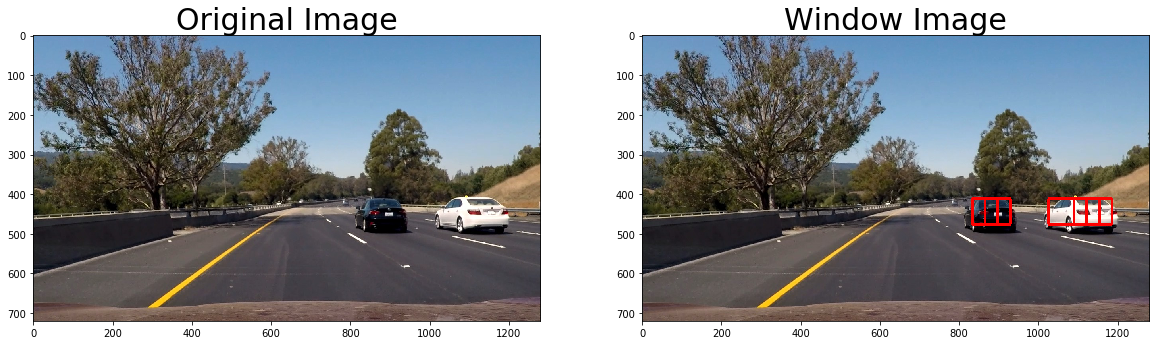

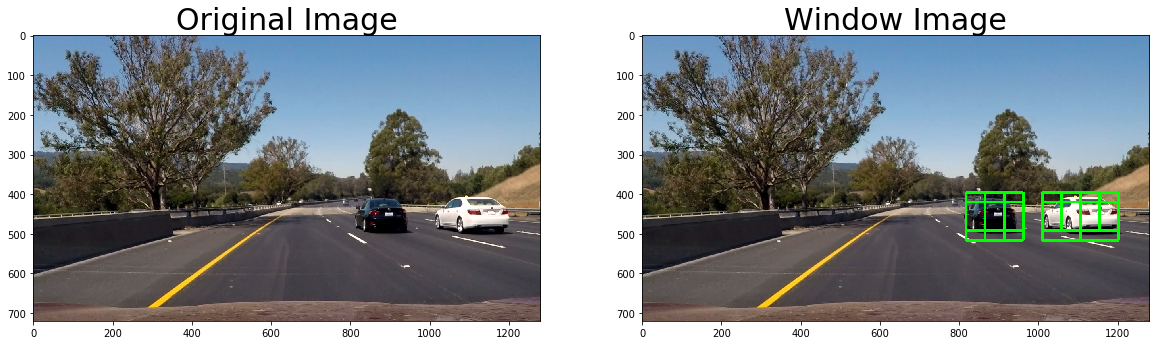

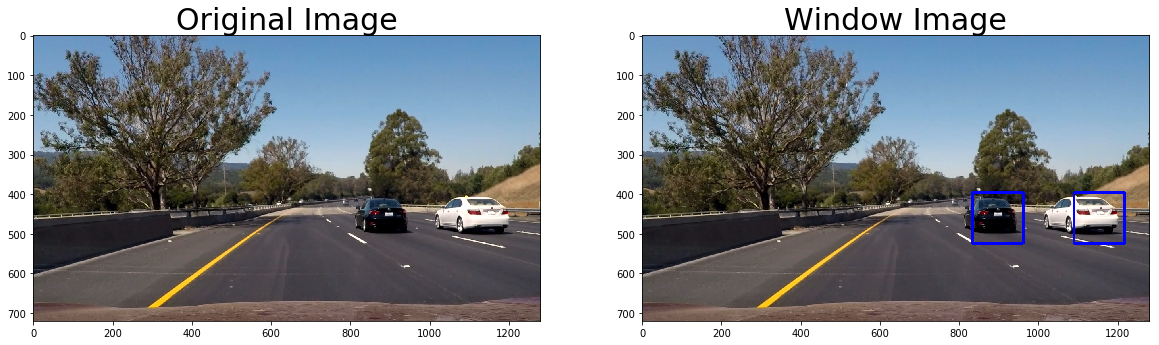

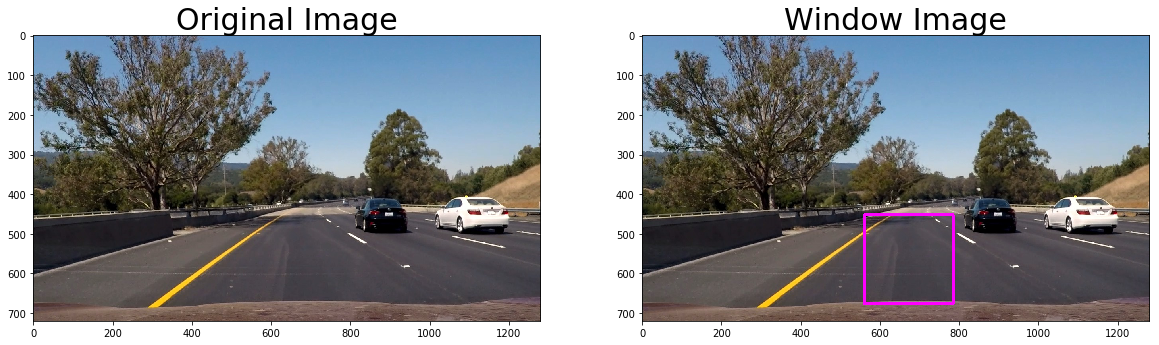

In [8]:
img = mpimg.imread('./test_images/test6.jpg')

for scale in np.array([1.0, 1.5, 2.0, 3.5]):
    window_img = np.copy(img)
    
    all_detected_window = []

    ystart = int(img.shape[0] * 0.55)
    ystop = ystart + int(window*scale*1.25)
        
    window_img, detected_window = find_cars(window_img, color_space, ystart, ystop, scale, 
                                             svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                                             spatial_size, hist_bins)
        
    if detected_window != []:
        all_detected_window += detected_window

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(window_img)
    ax2.set_title('Window Image', fontsize=30)

In [9]:
def createHeatmap(img, all_detected_window, threshold):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Count 'hot' area
    for bbox in all_detected_window:
        heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1

    # Apply threshold
    heatmap[heatmap <= threshold] = 0

    # Limit the counted value within the range of 0~255
    return np.clip(heatmap, 0, 255)


def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox),np.min(nonzeroy)), (np.max(nonzerox),np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

    return img

In [ ]:
from scipy.ndimage.measurements import label


img_list = glob.glob('./test_images/test*.jpg')
for img_file in img_list:
    img = mpimg.imread(img_file)
    window_img = np.copy(img)
    
    all_detected_window = []
    for scale in np.array([1.0, 1.5, 2.0, 3.5]):
        ystart = int(img.shape[0] * 0.55)
        ystop = ystart + int(window*scale*1.25)
        
        window_img, detected_window = find_cars(window_img, color_space, ystart, ystop, scale, 
                                             svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                                             spatial_size, hist_bins)
        
        if detected_window != []:
            all_detected_window += detected_window
            
    # Create a heat map
    heatmap = createHeatmap(img, all_detected_window, threshold=3)
    
    # Border detected cars based on the heat map
    boundary_img = draw_labeled_bboxes(np.copy(img), label(heatmap))

    # Plot the result
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(window_img)
    ax1.set_title('Window Image', fontsize=30)
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('Heat map', fontsize=30)
    ax3.imshow(boundary_img)
    ax3.set_title('Boundary Image', fontsize=30)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## 4. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


# For cv2.undistort()
dist_pickle = pickle.load(open("./camera_cal/wide_dist_pickle.p", "rb"))
mtx, dist = dist_pickle["mtx"], dist_pickle["dist"]


def process_image(img):
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx) # (720, 1280, 3)
    
    window_img = np.copy(img)
    
    all_detected_window = []
    for scale in np.array([1.0, 1.5, 2.0, 3.5]):
        ystart = int(img.shape[0] * 0.55)
        ystop = ystart + int(window*scale*1.25)
        
        window_img, detected_window = find_cars(window_img, color_space, ystart, ystop, scale, 
                                             svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                                             spatial_size, hist_bins)
        
        if detected_window != []:
            all_detected_window += detected_window
            
    # Create a heat map
    heatmap = createHeatmap(img, all_detected_window, threshold=3)
    
    # Border detected cars based on the heat map
    boundary_img = draw_labeled_bboxes(np.copy(img), label(heatmap))

    return boundary_img


file_name = 'test_video'
#file_name = 'project_video'

clip1 = VideoFileClip('./' + file_name + '.mp4')
#clip1 = VideoFileClip('./' + file_name + '.mp4').subclip(0,30)
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

output = './output_videos/' + file_name + '_output.mp4'
%time clip.write_videofile(output, audio=False)

## 5. Estimate a bounding box for vehicles detected.